**DataWrangler - useful VSCode extention**


In [17]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from typing import List, Tuple
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
train = pd.read_csv("train.csv")
train['Class'] = train['Class'].astype('category')
test = pd.read_csv("test.csv")

*Предварительный анализ табличного датасета*

In [7]:
def describe_NaN_df(df: pd.DataFrame):
    na_counts = df.isna().sum()
    res = pd.DataFrame({
        "feature": df.columns,
        "NaN_count": na_counts.values,
        "dtype": df.dtypes.values,
        "share":  (na_counts / len(df)).round(3).values
    })
    return res

In [8]:
describe_NaN_df(train)

,feature,NaN_count,dtype,share
0,Id,0,object,0.000
1,AB,0,float64,0.000
2,AF,0,float64,0.000
3,AH,0,float64,0.000
4,AM,0,float64,0.000
5,AR,0,float64,0.000
6,AX,0,float64,0.000
7,AY,0,float64,0.000
8,AZ,0,float64,0.000
9,BC,0,float64,0.000


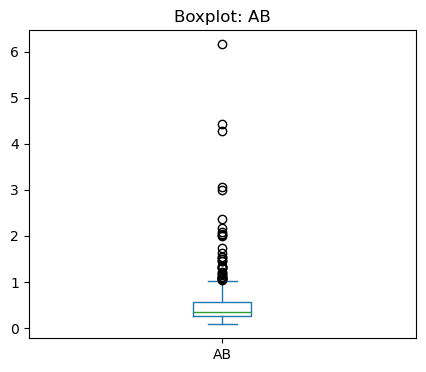

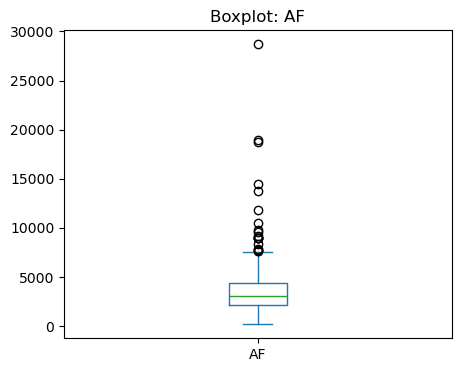

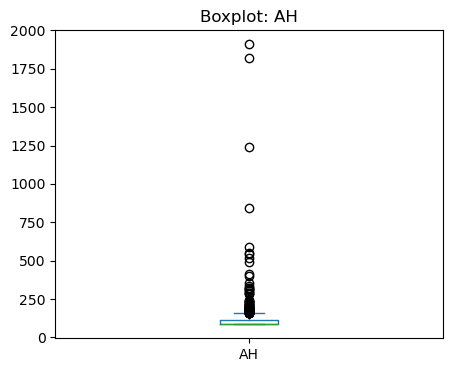

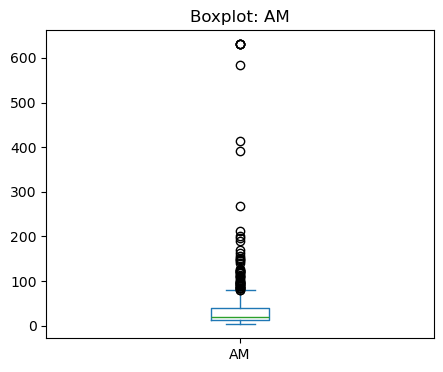

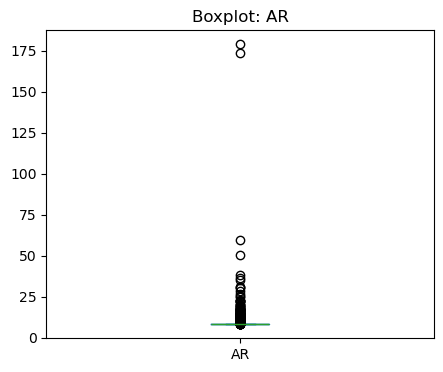

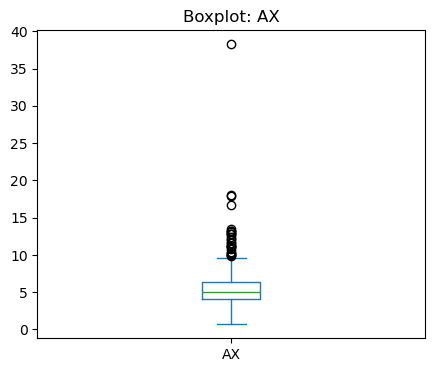

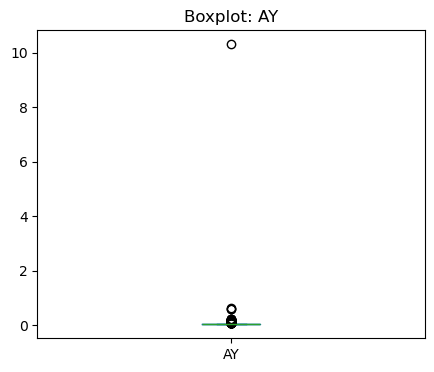

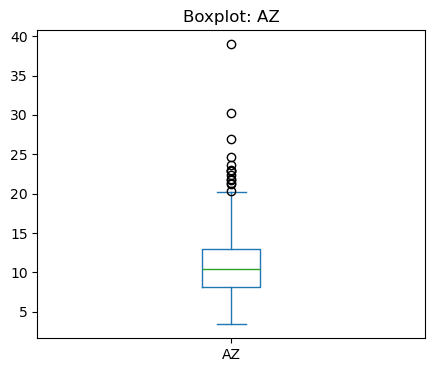

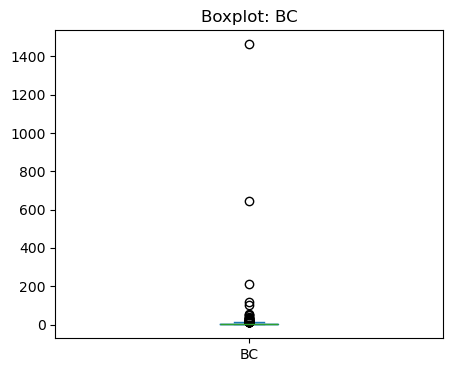

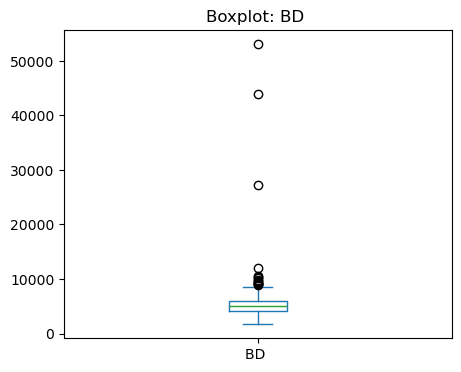

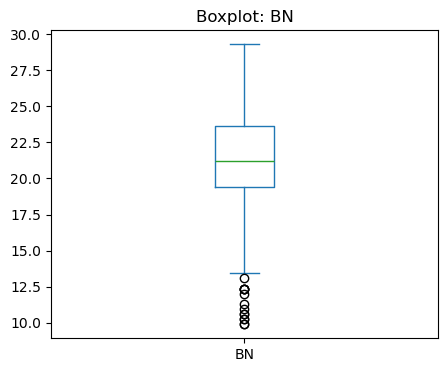

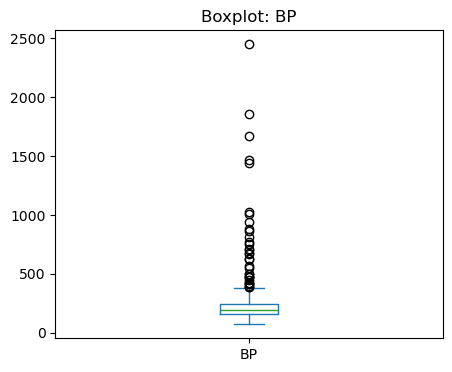

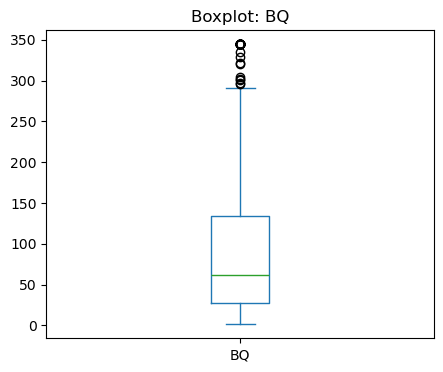

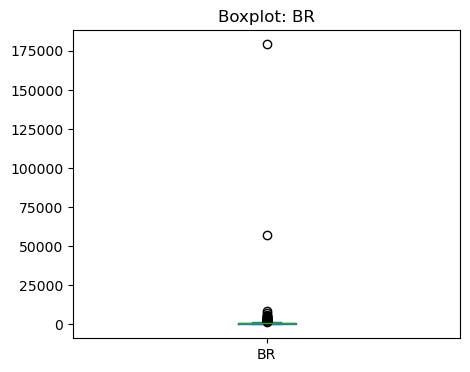

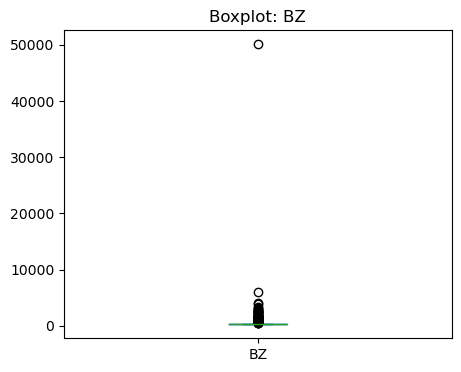

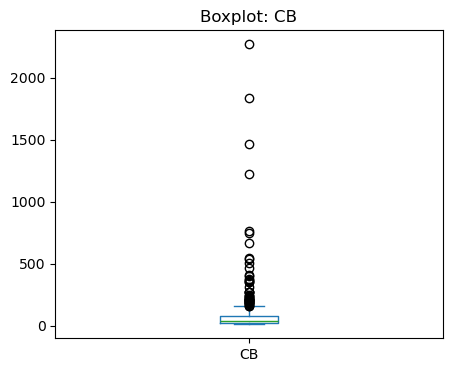

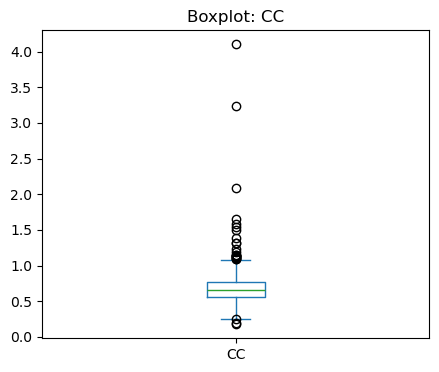

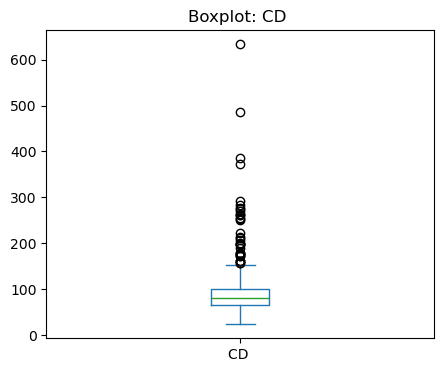

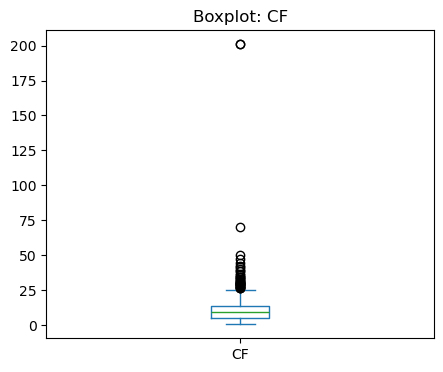

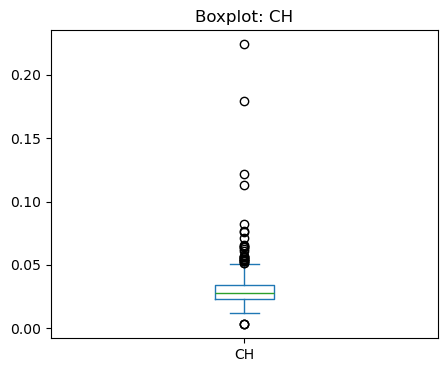

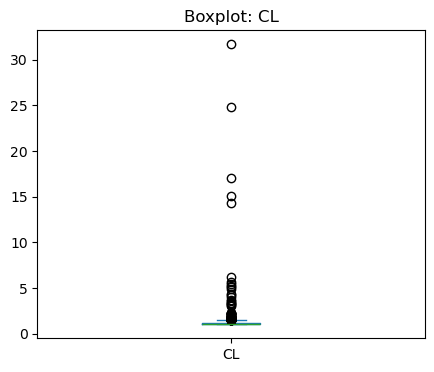

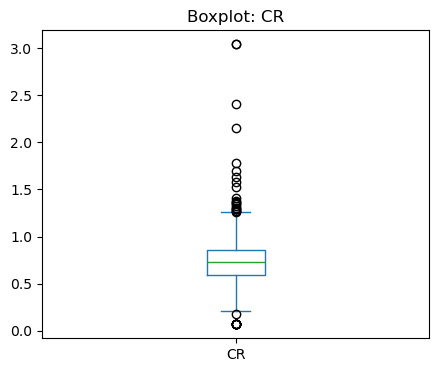

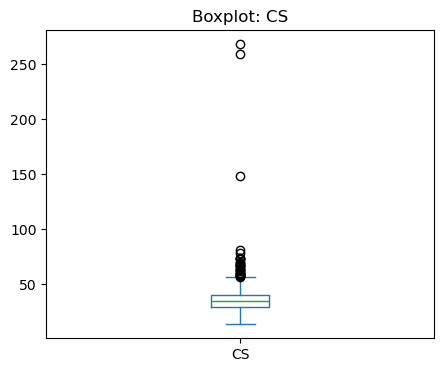

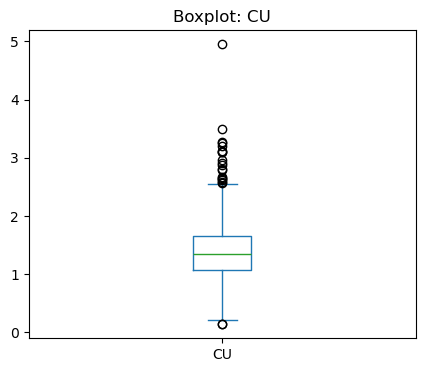

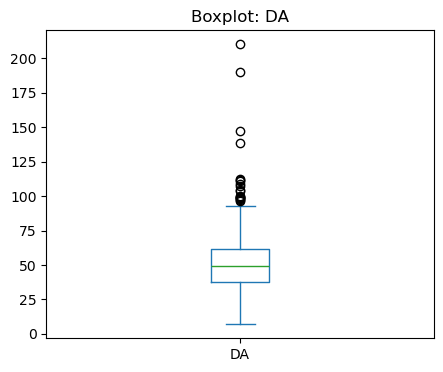

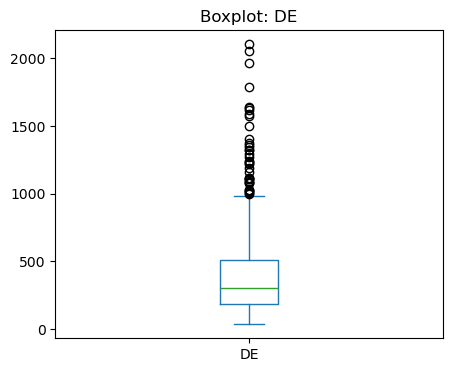

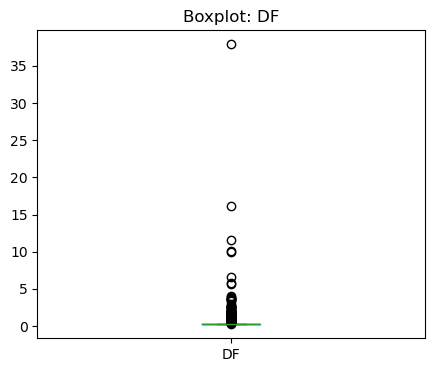

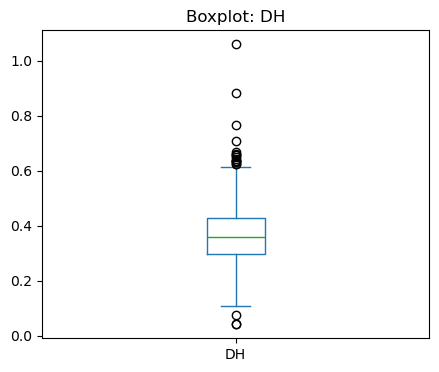

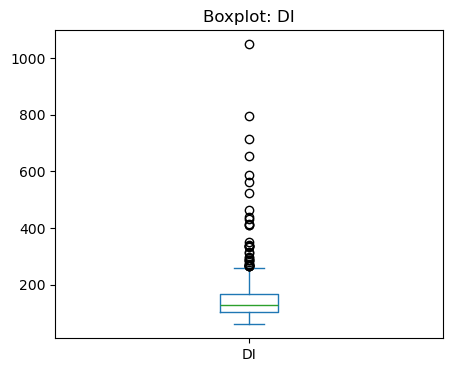

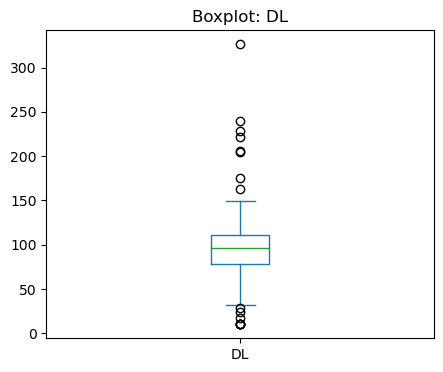

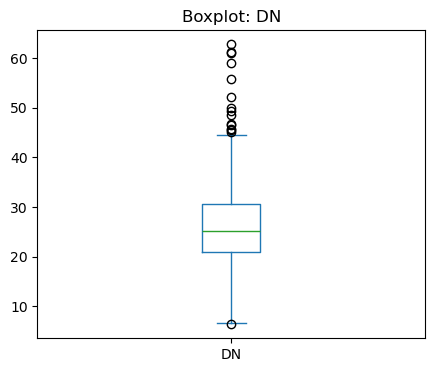

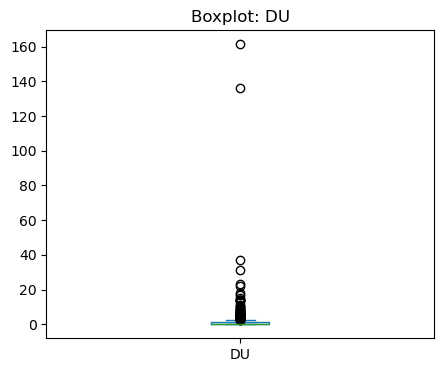

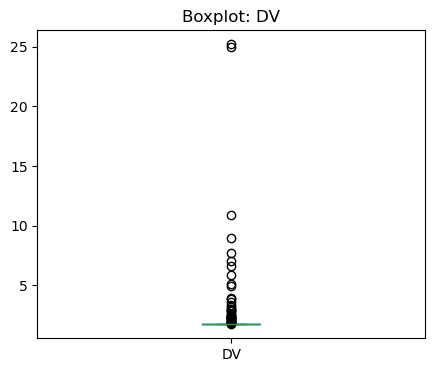

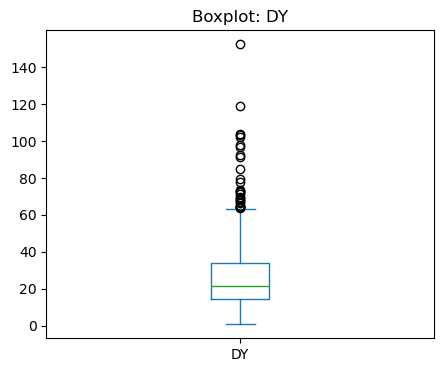

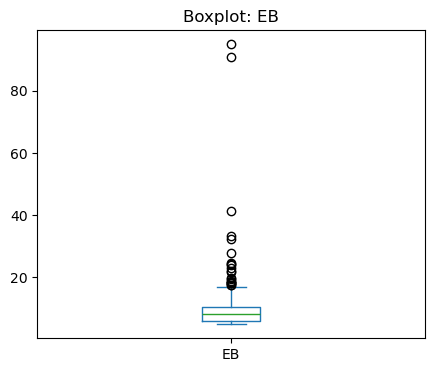

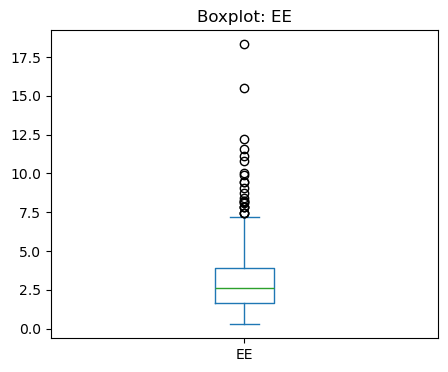

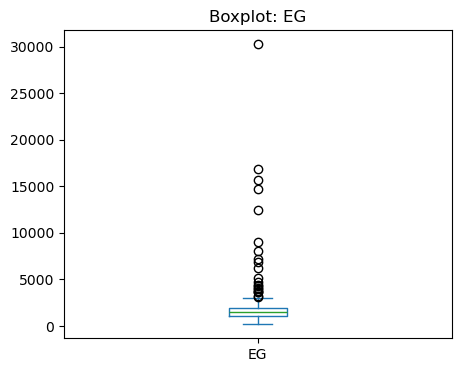

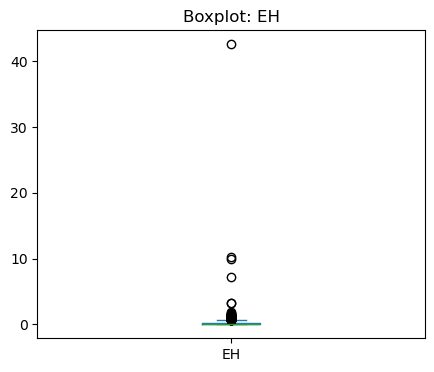

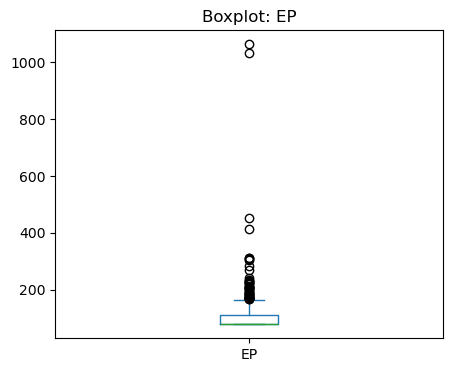

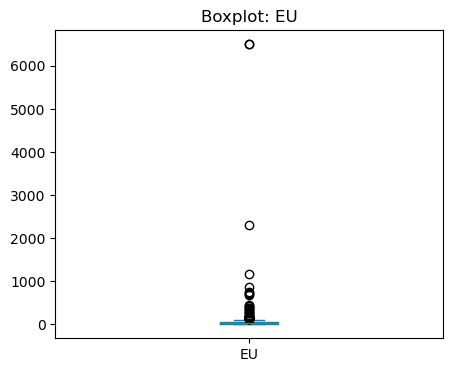

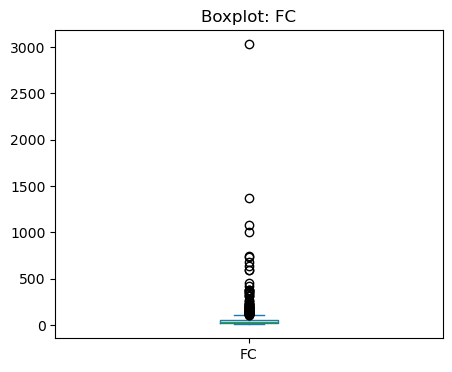

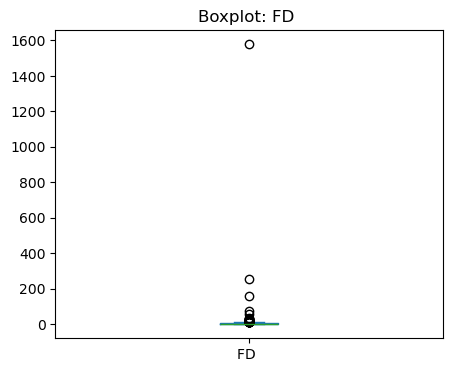

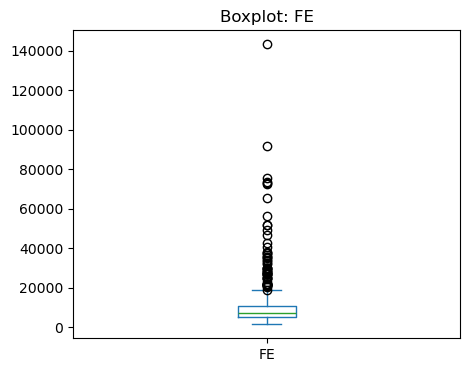

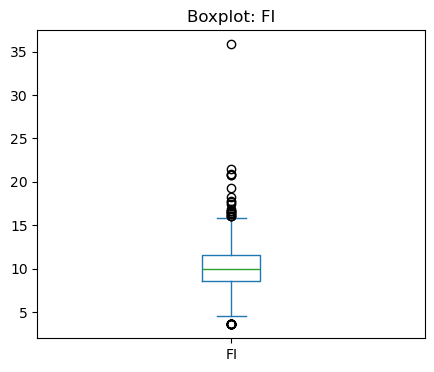

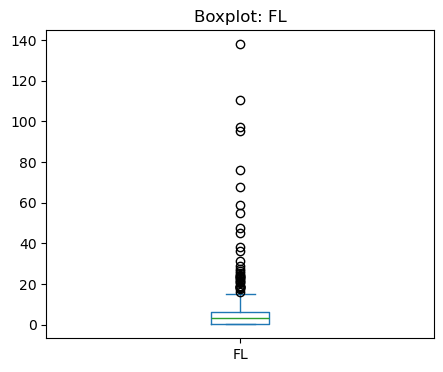

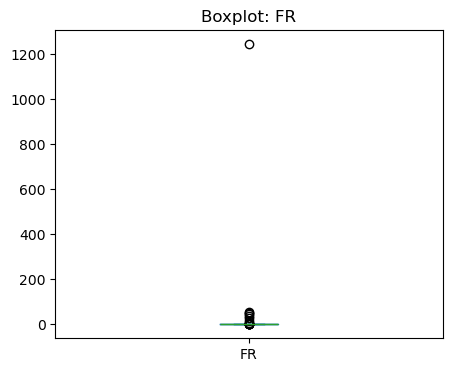

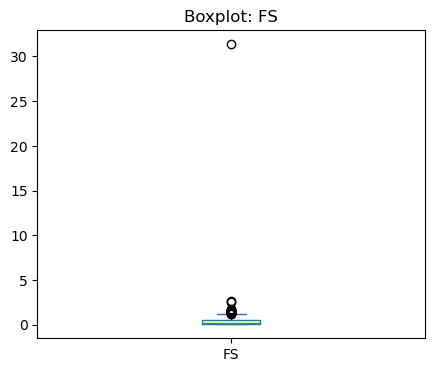

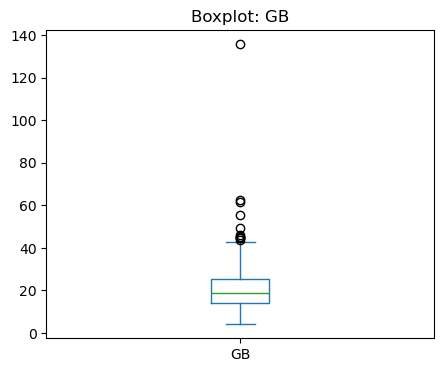

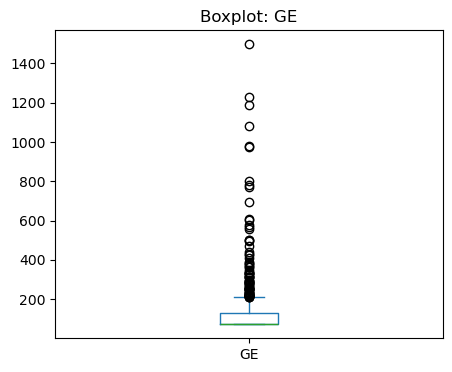

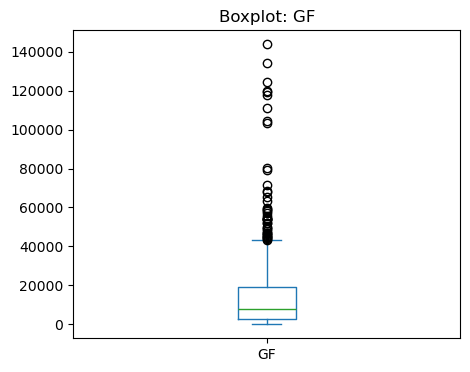

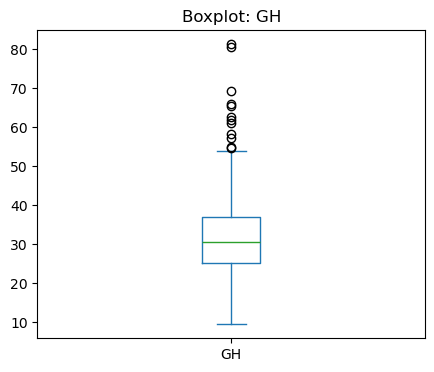

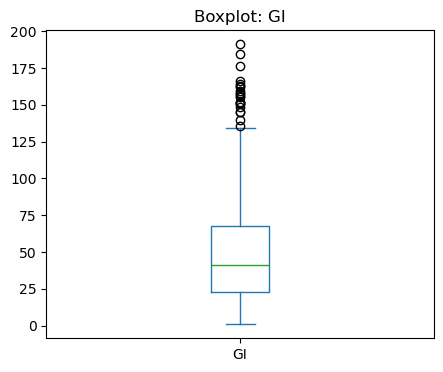

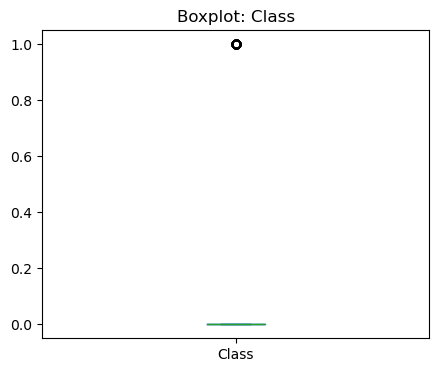

In [10]:
def detect_outliers_iqr(df: pd.DataFrame, factor: float = 1.5):
    outlier_features = []
    for col in df.select_dtypes(include='number').columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        # проверяем, есть ли значения вне диапазона
        if ((df[col] < lower) | (df[col] > upper)).any():
            outlier_features.append(col)
    return outlier_features

def plot_box(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    
    for col in columns:
        plt.figure(figsize=(5, 4))
        df[col].plot(kind='box')
        plt.title(f"Boxplot: {col}")
        plt.show()
        
cols = detect_outliers_iqr(train)
plot_box(train, cols)

In [21]:
def feature_report(df: pd.DataFrame, target: str, features=None):
    if features is None:
        features = [c for c in df.columns if c != target]
    
    if target not in df.columns:
        raise ValueError("Target не найден в DataFrame")

    target_is_numeric = pd.api.types.is_numeric_dtype(df[target])

    for col in features:
        print(f"\n===== {col} =====")
        is_num = pd.api.types.is_numeric_dtype(df[col])

        if is_num:
            mean = df[col].mean()
            median = df[col].median()
            print(f"mean: {mean:.3f}, median: {median:.3f}")

            if target_is_numeric:
                # Регрессия
                corr = df[col].corr(df[target])
                print(f"correlation with target: {corr:.3f}")
                
                plt.figure(figsize=(5,4))
                df[col].hist(bins=30)
                plt.title(f"Distribution of {col}")
                plt.show()
            
            else:
                # Классификация
                print("avg value by class:")
                print(df.groupby(target)[col].mean())

                plt.figure(figsize=(6,4))
                sns.boxplot(x=target, y=col, data=df)
                plt.title(f"{col} distribution by class ({target})")
                plt.show()

        else:
            print(f"unique values: {df[col].nunique()}")

            if target_is_numeric:
                # Категориальная при регрессии
                grouped = df.groupby(col)[target].mean().sort_values()
                print("mean target by category:")
                print(grouped)

                plt.figure(figsize=(6,4))
                grouped.plot(kind='bar')
                plt.title(f"Mean target by {col}")
                plt.show()
            
            else:
                # Категориальная при классификации
                cross = pd.crosstab(df[col], df[target], normalize='index')
                print("class distribution by category:")
                print(cross)

                plt.figure(figsize=(7,5))
                cross.plot(kind='bar', stacked=True)
                plt.title(f"Class distribution across {col}")
                plt.ylabel("share")
                plt.show()



===== EJ =====
unique values: 2
class distribution by category:
Class         0         1
EJ                       
A      0.873874  0.126126
B      0.797468  0.202532


<Figure size 700x500 with 0 Axes>

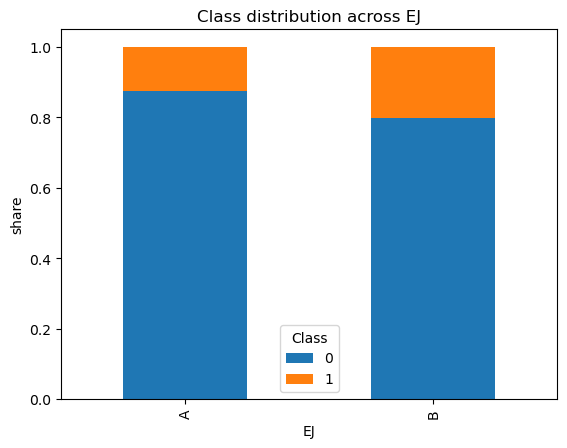


===== AM =====
mean: 38.969, median: 20.533
avg value by class:
Class
0    31.292888
1    75.143672
Name: AM, dtype: float64


C:\Users\Степан\AppData\Local\Temp\ipykernel_9988\1255719913.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(target)[col].mean())


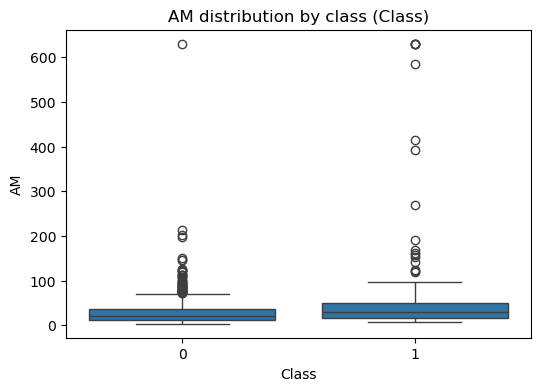

In [22]:
feature_report(train, target="Class", features=["EJ", "AM"])   # для выбранны

In [27]:
from scipy.stats import pointbiserialr, chi2_contingency

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


def target_correlations_general(df: pd.DataFrame, target: str):
    if target not in df.columns:
        raise ValueError("Таргет не найден в датафрейме")

    target_is_numeric = pd.api.types.is_numeric_dtype(df[target])
    results = []

    for col in df.columns:
        if col == target:
            continue

        col_dtype = df[col].dtype
        col_is_numeric = pd.api.types.is_numeric_dtype(df[col])

        if target_is_numeric:  # регрессия
            if col_is_numeric:
                corr = df[col].corr(df[target])
            else:
                corr = np.nan  # для категориальных можно добавить другой метод при необходимости
        else:  # классификация
            if df[target].nunique() == 2 and col_is_numeric:  # бинарная классификация
                y = df[target].astype('category').cat.codes
                corr, _ = pointbiserialr(df[col], y)
            else:  # многоклассовая или категориальная фича
                corr = cramers_v(df[col], df[target])

        results.append((col, col_dtype, corr))

    return (
        pd.DataFrame(results, columns=["feature", "dtype", "correlation_with_target"])
        .sort_values("correlation_with_target", ascending=False)
        .reset_index(drop=True)
    )

In [28]:
target_correlations_general(train, "Class")

,feature,dtype,correlation_with_target
0,Id,object,1.000000
1,AF,float64,0.302638
2,AB,float64,0.280612
3,DI,float64,0.260760
4,AM,float64,0.239170
5,FE,float64,0.216359
6,BN,float64,0.198283
7,EH,float64,0.179855
8,CD,float64,0.171304
9,BP,float64,0.157286


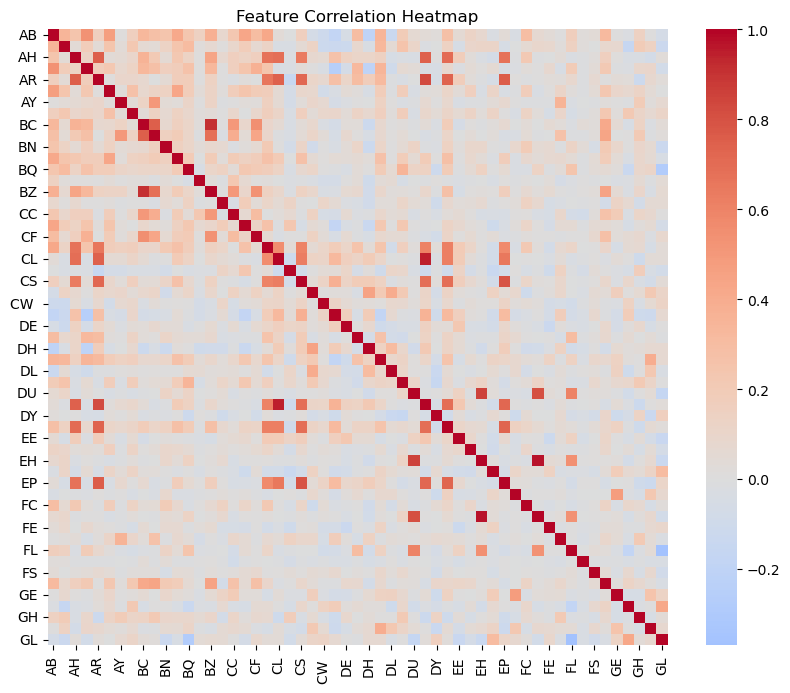

In [29]:
def plot_corr_heatmap(df: pd.DataFrame):
    corr = df.select_dtypes(include='number').corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

plot_corr_heatmap(train)

**Генерация фичей**

In [ ]:
# Кластеры


from sklearn.cluster import KMeans

def add_multiple_kmeans_clusters(train_path: str, test_path: str, random_state: int = 42):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    feature_cols = [c for c in train_df.columns if c.startswith('feat_')]
    X_train = train_df[feature_cols].values
    X_test = test_df[feature_cols].values

    cluster_counts = [2, 10, 20]

    for n_clusters in cluster_counts:
        print(f"Обучаем KMeans для k={n_clusters}...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
        kmeans.fit(X_train)

        train_df[f'cluster_{n_clusters}'] = pd.Categorical(kmeans.predict(X_train))
        test_df[f'cluster_{n_clusters}'] = pd.Categorical(kmeans.predict(X_test))

    # train_df.to_csv('train_with_multi_clusters.csv', index=False)
    # test_df.to_csv('test_with_multi_clusters.csv', index=False)

    # print("Файлы сохранены: train_with_multi_clusters.csv и test_with_multi_clusters.csv")

    return train_df, test_df
add_multiple_kmeans_clusters("train_bert_features.csv", "test_bert_features.csv")


In [ ]:
# Значения таргета усредненные по соседям


from sklearn.neighbors import NearestNeighbors


def add_knn_features(train_df, test_df, feature_prefix="feat_", target_col="target", n_neighbors=20):
    feat_cols = [col for col in train_df.columns if col.startswith(feature_prefix)]
    
    valid_train = ~train_df[feat_cols].isna().any(axis=1)
    valid_test = ~test_df[feat_cols].isna().any(axis=1)
    
    model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
    model.fit(train_df.loc[valid_train, feat_cols])
    
    for stat_name in ["mean", "std", "min", "max"]:
        train_df[f"knn_target_{stat_name}"] = np.nan
        test_df[f"knn_target_{stat_name}"] = np.nan
    
    dists, idxs = model.kneighbors(train_df.loc[valid_train, feat_cols])
    neigh_targets = train_df.loc[valid_train, target_col].values[idxs]
    train_df.loc[valid_train, "knn_target_mean"] = neigh_targets.mean(axis=1)
    train_df.loc[valid_train, "knn_target_std"] = neigh_targets.std(axis=1)
    train_df.loc[valid_train, "knn_target_min"] = neigh_targets.min(axis=1)
    train_df.loc[valid_train, "knn_target_max"] = neigh_targets.max(axis=1)
    
    dists, idxs = model.kneighbors(test_df.loc[valid_test, feat_cols])
    neigh_targets = train_df.loc[valid_train, target_col].values[idxs]
    test_df.loc[valid_test, "knn_target_mean"] = neigh_targets.mean(axis=1)
    test_df.loc[valid_test, "knn_target_std"] = neigh_targets.std(axis=1)
    test_df.loc[valid_test, "knn_target_min"] = neigh_targets.min(axis=1)
    test_df.loc[valid_test, "knn_target_max"] = neigh_targets.max(axis=1)
    
    return train_df, test_df

train, test = add_knn_features(train, test)

In [ ]:
def apply_ratio_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    def ratio(a, b): 
        return np.where(b != 0, a / b, 0)

    df['traffic_density_ratio'] = ratio(df['traffic_300m'], df['traffic_1000m'])
    df['homes_density_ratio'] = ratio(df['homes_300m'], df['homes_1000m'])
    df['works_density_ratio'] = ratio(df['works_300m'], df['works_1000m'])
    df['female_ratio'] = ratio(df['female_300m'], df['female_1000m'])
    df['employed_ratio'] = ratio(df['employed_300m'], df['unemployed_300m'] + 1)
    df['children_ratio'] = ratio(df['has_children_300m'], df['no_children_300m'] + 1)

    return df

In [ ]:
from typing import List, Optional
import itertools

def multiply_features(df: pd.DataFrame, feature_list: Optional[List[str]] = None) -> pd.DataFrame:
    # Если список не задан, берем все числовые колонки
    if feature_list is None:
        feature_list = df.select_dtypes(include="number").columns.tolist()

    result = df.copy()

    # Перемножаем каждую пару
    for f1, f2 in itertools.combinations(feature_list, 2):
        result[f"{f1}_x_{f2}"] = result[f1] * result[f2]

    return result

**Текстовые фичи**

In [ ]:
import re

def add_text_features(df: pd.DataFrame) -> pd.DataFrame:
    # Копируем, чтобы не менять оригинал
    df = df.copy()

    # выбираем текстовые колонки
    text_cols = df.select_dtypes(include=["object", "string"]).columns

    for col in text_cols:
        # базовые статистики
        df[f"{col}_len"] = df[col].astype(str).apply(len)  # длина строки
        df[f"{col}_word_count"] = df[col].astype(str).apply(lambda x: len(x.split()))  # число слов

        # количество уникальных слов (приближенно)
        df[f"{col}_unique_word_count"] = df[col].astype(str).apply(lambda x: len(set(x.split())))

        # средняя длина слова
        df[f"{col}_avg_word_len"] = df[col].astype(str).apply(
            lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
        )

        # количество цифр
        df[f"{col}_digit_count"] = df[col].astype(str).apply(lambda x: sum(ch.isdigit() for ch in x))

        # количество букв верхнего регистра
        df[f"{col}_upper_count"] = df[col].astype(str).apply(lambda x: sum(ch.isupper() for ch in x))

        # количество букв нижнего регистра
        df[f"{col}_lower_count"] = df[col].astype(str).apply(lambda x: sum(ch.islower() for ch in x))

        # доля заглавных букв
        df[f"{col}_upper_ratio"] = (
            df[f"{col}_upper_count"] / df[f"{col}_len"].replace(0, np.nan)
        )

        # количество знаков пунктуации
        df[f"{col}_punct_count"] = df[col].astype(str).apply(
            lambda x: len(re.findall(r"[^\w\s]", x))
        )

        # доля уникальных слов
        df[f"{col}_unique_word_ratio"] = (
            df[f"{col}_unique_word_count"] / df[f"{col}_word_count"].replace(0, np.nan)
        )

        # количество повторяющихся слов
        df[f"{col}_repeated_word_count"] = df[col].astype(str).apply(
            lambda x: sum(x.split().count(w) > 1 for w in set(x.split()))
        )

        # бинарная фича: содержит ли число
        df[f"{col}_has_digit"] = df[col].astype(str).apply(lambda x: any(ch.isdigit() for ch in x)).astype(int)

        # бинарная фича: содержит ли URL
        url_pattern = r"https?://\S+|www\.\S+"
        df[f"{col}_has_url"] = df[col].astype(str).apply(lambda x: bool(re.search(url_pattern, x))).astype(int)

    return df

In [ ]:
# pip install textblob
from textblob import TextBlob

def sentiment_features(df: pd.DataFrame, text_col) -> pd.DataFrame:
    df[f"{text_col}_polarity"] = df[text_col].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
    df[f"{text_col}_subjectivity"] = df[text_col].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

text_df = pd.read_csv("path.csv")

# df = (
#     reviews
#     .groupby('id', as_index=False)
#     .agg({'text': ' '.join})
# )

texts = text_df["text"].tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

from sklearn.decomposition import TruncatedSVD

n_components = 256

svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced = svd.fit_transform(tfidf_matrix)


print(f"Объяснённая дисперсия: {svd.explained_variance_ratio_.sum():.4f}")

reduced_df = pd.DataFrame(reduced, columns=[f"feat_{i}" for i in range(n_components)])
reduced_df["id"] = text_df["id"].values


reduced_df.to_csv("tfidf_features.csv", index=False)

**Обучение Моделей**

In [4]:
X, y = train.drop(columns=['Class']), train['Class']

In [5]:
def preprocess(df: pd.DataFrame, is_train: bool=True) -> Tuple[pd.DataFrame, List[str]]:
    result_df = df.copy()
    result_df.drop(columns=["Id"], inplace=True)

    for col in result_df.select_dtypes(include=['object', 'category']).columns:
        result_df[col] = result_df[col].fillna("missing").astype('category')

    cat_features = result_df.select_dtypes(include=['category']).columns.tolist()
    return result_df, cat_features


In [6]:
X, cat_features = preprocess(X)

In [7]:
def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.3, step=0.01),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, step=0.5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
        "iterations": 5000,
        "early_stopping_rounds": 200,
        "task_type": "GPU",
        "random_seed": 42,
        "verbose": False,
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        train_pool = Pool(X.iloc[train_idx], y.iloc[train_idx], cat_features=cat_features)
        val_pool = Pool(X.iloc[val_idx], y.iloc[val_idx], cat_features=cat_features)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, verbose=False)

        scores.append(model.best_score_["validation"]["Logloss"])

    return np.mean(scores)



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

[I 2025-11-06 12:08:38,506] A new study created in memory with name: no-name-88ee4a95-24d5-4c0d-80f0-d566f42b1ee1
[I 2025-11-06 12:10:25,561] Trial 0 finished with value: 0.17730040351393464 and parameters: {'learning_rate': 0.19, 'depth': 7, 'l2_leaf_reg': 8.5, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.17730040351393464.
[I 2025-11-06 12:11:36,559] Trial 1 finished with value: 0.17016935075889444 and parameters: {'learning_rate': 0.06, 'depth': 4, 'l2_leaf_reg': 4.5, 'min_data_in_leaf': 27}. Best is trial 1 with value: 0.17016935075889444.
[W 2025-11-06 12:11:50,840] Trial 2 failed with parameters: {'learning_rate': 0.25, 'depth': 9, 'l2_leaf_reg': 9.5, 'min_data_in_leaf': 52} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Степан\AppData

KeyboardInterrupt: 

In [ ]:
best_catboost_params = {'learning_rate': 0.02, 'depth': 5}

*классификация*

In [ ]:
catboost_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_catboost_models = []

for fold, (train_index, val_index) in enumerate(catboost_kf.split(X, y)):
    print(f"\nОбучение на фолде {fold + 1}...")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",
        iterations=1000,
        early_stopping_rounds=100,
        task_type="GPU",
        random_seed=42,
        verbose=100,
        **best_catboost_params
    )

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_val, y_val)])
    best_catboost_models.append(model)

    y_prob = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    auc = roc_auc_score(y_val, y_prob)

    print(f"Fold {fold+1} | Precision: {precision:.4f} | Recall: {recall:.4f} | Weighted F1: {f1:.4f} | AUC-ROC: {auc:.4f}")



Обучение на фолде 1...
0:	learn: 0.6662526	test: 0.6693025	best: 0.6693025 (0)	total: 29.1ms	remaining: 29.1s
100:	learn: 0.1416575	test: 0.2319636	best: 0.2319636 (100)	total: 2.17s	remaining: 19.4s
200:	learn: 0.0778335	test: 0.2009051	best: 0.2007579 (199)	total: 4.33s	remaining: 17.2s
300:	learn: 0.0460629	test: 0.1852348	best: 0.1852348 (300)	total: 6.46s	remaining: 15s
400:	learn: 0.0282411	test: 0.1776181	best: 0.1773985 (396)	total: 8.6s	remaining: 12.8s
500:	learn: 0.0184382	test: 0.1755568	best: 0.1749414 (493)	total: 10.9s	remaining: 10.8s
600:	learn: 0.0131213	test: 0.1752924	best: 0.1748334 (596)	total: 13s	remaining: 8.65s
700:	learn: 0.0100856	test: 0.1747634	best: 0.1745530 (686)	total: 15.1s	remaining: 6.46s
800:	learn: 0.0080418	test: 0.1751603	best: 0.1737513 (734)	total: 17.2s	remaining: 4.28s
bestTest = 0.1737512773
bestIteration = 734
Shrink model to first 735 iterations.
Fold 1 | Precision: 0.9231 | Recall: 0.5455 | Weighted F1: 0.9018 | AUC-ROC: 0.9773

Обучени

*регрессия*

R² = 1 — модель идеально объясняет данные

R² = 0 — модель ничем не лучше простого среднего

R² < 0 — модель хуже, чем просто предсказывать среднее

In [ ]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# catboost_kf = KFold(n_splits=5, shuffle=True, random_state=42)
# best_catboost_models = []

# for fold, (train_index, val_index) in enumerate(catboost_kf.split(X, y)):
#     print(f"\nОбучение на фолде {fold + 1}...")

#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     model = CatBoostRegressor(
#         loss_function="RMSE",
#         eval_metric="RMSE",
#         iterations=1000,
#         early_stopping_rounds=100,
#         task_type="GPU",
#         random_seed=42,
#         verbose=100,
#         **best_catboost_params
#     )

#     model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_val, y_val)])
#     best_catboost_models.append(model)

#     y_pred = model.predict(X_val)

#     mae = mean_absolute_error(y_val, y_pred)
#     mse = mean_squared_error(y_val, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_val, y_pred)
#     mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

#     print(f"Fold {fold+1} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")


In [11]:
test, _ = preprocess(test)

In [13]:
probas = np.zeros(len(test))

for model in best_catboost_models:
    probas += model.predict_proba(test)[:, 1]

probas /= len(best_catboost_models)

In [14]:
test = pd.read_csv("test.csv")

In [15]:
submission_df = pd.DataFrame({
    "Id": test['Id'],
    "class_0": 1 - probas,
    "class_1": probas
})
submission_df.to_csv("catboost1.csv", index=False)